# Task 1 Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.


## Step 1 : Collect the Data

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

/Users/sennanli/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
df = pd.DataFrame()
df["reviews"] = reviews

In [5]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

## Step 2: Clean the Data

### Remove unwanted text 

In [6]:
def remove_unwanted_text(text, unwanted_substring): 
    return re.sub(unwanted_substring, '', text, flags=re.IGNORECASE) 

df['reviews'] = df['reviews'].apply(lambda review: remove_unwanted_text(review, '✅ Trip Verified'))
df['reviews'] = df['reviews'].apply(lambda review: remove_unwanted_text(review, 'Not Verified'))

## Step 3: Analyse the Data

### 1. Wordcloud Analysis

In [7]:
# Combine all reviews into one string
all_reviews = ' '.join(df['reviews'])

In [8]:
# Create a WordCloud object

wc = WordCloud(
               stopwords=set(STOPWORDS).union({"BA"}), 
               background_color='white',
               mask=np.array(PIL.Image.open("British-Airways-Symbol.png"))
              ).generate(all_reviews)

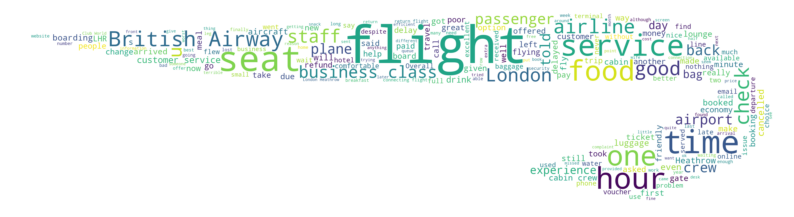

In [9]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Sentiment Analysis

In [10]:
# Function to get sentiment 
def get_sentiment(text): 
    blob = TextBlob(text) 
    return blob.sentiment.polarity

# Apply the function to each review
df['polarity score'] = df['reviews'].apply(lambda review: pd.Series(get_sentiment(review)))
df.head()

,reviews,polarity score
0,"| I had visa issues, and hence, was debarre...",0.166364
1,| Singapore to Heathrow with BA. Two choice...,0.214491
2,| I recently travelled from Munich to Londo...,-0.016706
3,| I paid for seats 80 A and B on my flight f...,0.017572
4,"| The flight wasn’t that bad, although the In...",0.162037


In [11]:
def get_polarity(score): 
   if score > 0:
       return "Positive"
   elif score < 0:
       return "Negative"
   else:
       return "Neutral"
df['polarity'] = df['polarity score'].apply(lambda score: get_polarity(score))

In [73]:
df.loc[df['polarity'] == "Neutral"]

reviews           12
polarity score    12
polarity          12
dtype: int64

In [75]:
value_counts = df["polarity"].value_counts()
value_counts

polarity
Positive    615
Negative    373
Neutral      12
Name: count, dtype: int64

In [49]:
value_percentages = (value_counts / value_counts.sum()) * 100
value_percentages

polarity
Positive    61.5
Negative    37.3
Neutral      1.2
Name: count, dtype: float64

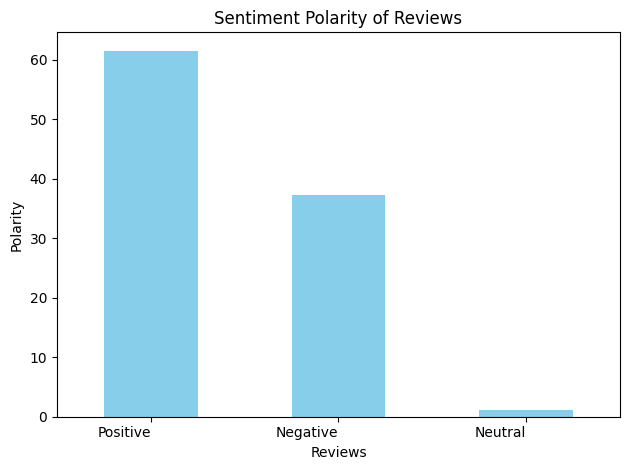

In [63]:
# Plot the sentiment polarity 

value_percentages.plot(kind='bar', color='skyblue')
plt.title('Sentiment Polarity of Reviews') 
plt.xlabel('Reviews') 
plt.ylabel('Polarity')
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [71]:
df.to_csv('data/output.csv', index=False)